In [ ]:
import numpy as np
from pathlib import Path
import warnings
from matplotlib import pyplot as plt
from collections import OrderedDict
from scipy import stats
from loess.loess_2d import loess_2d

from calc_fwhm import *

import os
import sys
current_dir = os.path.dirname(os.path.abspath(__file__))
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
# Allows for computing 
astrometry_dir = os.path.abspath(os.path.join(parent_dir, 'astrometry'))
sys.path.append(parent_dir)
sys.path.append(astrometry_dir)
from convenience_funcs.convenience_funcs import *
from astrometry.plate_scale import avg_plate_scale



def testing():
    # directories = [Path(f'C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-06-24/raw-reduced/109_199_{filt}') for filt in ['B', 'V', 'R', 'I']]

    # rawdir = Path("")
    # rawdir = Path("C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-05-12/raw")  # path to directory with raw data

    # image_to_analyze = Path("C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-05-12/raw/d1079.fits")  # path to directory with raw data

    # Initial configuration
    # directories = [Path(f'C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-06-24/raw-reduced/PG1530+057_{filt}') for filt in ['B', 'V', 'R', 'I']]
    # Night 1 mod
    # directories = [Path(f'C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-06-24/raw-reduced/109_231_{filt}') for filt in ['R']]

    # reddir = Path(f'C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-05-12/raw-reduced/')
    # directories = [dir for dir in reddir.iterdir() if 'flat' not in str(dir)]

    # reddir = Path(f'C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-06-26/raw-reduced/')
    # directories = [dir for dir in reddir.iterdir() if ('Focus' not in str(dir) and 'NGC' not in str(dir))]
    # graph_fwhms_by_setting(directories, condition_tuples=conditions_06_26)
    
    # reddir = Path(f'C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-06-26/raw-reduced/')
    # directories = [dir for dir in reddir.iterdir() if ('Focus' not in str(dir) and 'NGC' not in str(dir))]
    # graph_fwhms_by_setting(directories, condition_tuples=conditions_06_26)

    # reddir = Path(f'C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-06-26/raw-reduced/')
    # directories = [dir for dir in reddir.iterdir() if ('109_199' in str(dir))]
    # graph_fwhms_by_image(directories, '06-26-24')

    # bias, flat = generate_reduction_files(rawdir)
    # fwhm = fwhm_from_raw(image_to_analyze, bias, flat)
    
    reddir = Path(f'C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-06-26/raw-reduced/')
    directories = [dir for dir in reddir.iterdir() if ('NGC' not in str(dir) and 'Focus' not in str(dir))]
    graph_topographic(directories, conditions_06_26)

default_fwhm_default=5.0
thresh_default=15
aper_size_default=8
local_bkg_range_default=(15,20)


def graph_fwhms_by_image(directories, date=None, files=None, plot=False, max_std=0.5):
    avg, data = batch_fwhm(directories, plot=plot, files=files, max_std=max_std)
    data.sort()
    image_numbers, fwhms, stds, objects = zip(*data)
    unique_objects = list(OrderedDict.fromkeys(objects))
    if date is None:
        print("Date in title may be inaccurate")
        date = directories[0].parent.parent.name[-5:]

    # Plot the values relative to image numbers, with different colors for different objects
    plt.figure(figsize=(10, 6))
    plt.plot(image_numbers, fwhms, marker='o', linestyle='-', color='#808080', zorder=1, label='FWHM')
    plt.plot(image_numbers, stds, marker='s', linestyle='-', color='#B3B3B3', zorder=1, label='STD')
    for obj in unique_objects:
        obj_data = [(img_num, fwhm, std) for img_num, fwhm, std, obj_name in data if obj_name == obj]
        obj_image_numbers, obj_fwhms, obj_stds = zip(*obj_data)
        # plt.scatter(obj_image_numbers, obj_stds, marker='s', label=obj, zorder=2)
        plt.scatter(obj_image_numbers, obj_fwhms, marker='o', label=obj, zorder=2)  # Add lines and points
    
    plt.xlabel('Image Number')
    plt.ylabel('FWHM Value')
    plt.title(f'FWHM Value vs. Image Number - {date}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    min_num = min(image_numbers)
    max_num = max(image_numbers)
    plt.xticks(range(min_num, max_num + 1, max(1, int((max_num-min_num)/20))))
    plt.show()

    return avg


def graph_fwhms_by_setting(directories, condition_tuples, files=None):
    
    images = unzip_directories(directories, files, output_format='Fits_Simple')
    
    categories = categories_from_conditions(condition_tuples, images)
    
    data = []
    conf_intervals = []
    # Print out the categories and their corresponding file lists
    for category, file_list in categories.items():
        mean_fwhm, result_matrix = batch_fwhm(None, files=file_list, mode='all fwhms')
        data.append((category, mean_fwhm))

        # std/sqrt(n) = standard error (in/of the mean)

        image_numbers, fwhms, stds, objects = zip(*result_matrix)
        fwhms = np.hstack(fwhms).tolist()
        std_dev = np.std(fwhms, ddof=1) # Sample standard deviation
        
        confidence_level = 0.95 # Confidence level
        # Calculate the t-critical value
        t_critical = stats.t.ppf((1 + confidence_level) / 2, df=len(fwhms)-1)
        # Calculate the margin of error
        # margin_of_error = t_critical * (std_dev / np.sqrt(len(fwhms)))
        
        margin_of_error = std_dev / np.sqrt(len(fwhms))
        # Calculate the confidence interval
        # conf_intervals.append((margin_of_error,
        #                        margin_of_error))
        interval = stats.norm.interval(confidence=0.95, 
                                       loc=np.mean(fwhms), 
                                       scale=stats.sem(fwhms))
        conf_intervals.append((abs((interval[0] - mean_fwhm)), 
                               abs(interval[1] - mean_fwhm)))
    
    data.sort()
    widths, fwhms = zip(*data)
    conf_intervals = np.array(conf_intervals).T
    
    # Plot the plate_scales relative to widths, with different colors for different objects
    plt.figure(figsize=(8, 5))
    plt.errorbar(widths, fwhms, yerr=[conf_intervals[0], conf_intervals[1]], 
                 fmt='o', linestyle='-', ecolor='r', capsize=5, 
                 label=f'FWHM w/ {confidence_level*100}% Conf. Interval')
    plt.xlabel('Spacer Width (in)')
    plt.ylabel('FWHM (pixels)')
    plt.title(f'FWHM vs. Spacer Width')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    return data


def single_graph_topographic(directories, files=None, title="", frac=0.5, verbose=False):
    
    images = unzip_directories(directories, files, output_format='Fits_Simple')
    
    # Collect all coordinates and FWHMs in numpy arrays
    all_x, all_y, all_residuals = zip(*(calc_fwhm(image, mode='fwhm residuals', verbose=verbose) 
                                        for image in images))
    all_x = np.concatenate(all_x)
    all_y = np.concatenate(all_y)
    all_residuals = np.concatenate(all_residuals)
    
    plate_scale = avg_plate_scale(directories, files=files, verbose=verbose, fast=True)
    all_residuals = all_residuals * plate_scale
    
    # Create grid for interpolation
    grid_x, grid_y = np.mgrid[0:1024:3, 0:1024:3]
    
    # Interpolate data using griddate
    # grid_z = griddata((clipped_x, clipped_y), clipped_fwhm, (grid_x, grid_y), method='linear')
    
    # Interpolate data using Loess smoothing - computationally difficult
    print('loess_2d beginning')
    flat_z, wout = loess_2d(all_x, all_y, all_residuals, xnew=grid_x.flatten(),
                      ynew=grid_y.flatten(), frac=frac)
    print('loess_2d done')
    grid_z = flat_z.reshape(grid_x.shape)
    
    # Define the colors & range of contour levels
    colors = ["#cc0018", "#cd0000", "#cb4000", "#c97f00", "#c7bc00", "#91c400", "#52c200", 
              "#00bc62", "#00ba9c", "#009cb8", "#0061b6", "#1100b1", "#4800af", "#7e00ad"]
    levels = np.linspace(0.0, 1.3, len(colors))
    # levels = np.linspace(4.5, 7.5, 10)
    # colors = ["#b70000", "#b64d00", "#b59a00", "#82b300", "#00b117", 
    #           "#00afab", "#0067ae", "#001dac", "#2c00ab", "#7400aa"]
    
    # Plot contour map
    plt.figure()
    cp = plt.contourf(grid_x, grid_y, grid_z, levels=levels, colors=colors)
    plt.colorbar(cp)
    plt.title(f'FWHM Residuals (arcsec) Contour Map - {title}')
    plt.xlabel('X (pixels)')
    plt.ylabel('Y (pixels)')
    plt.show()
    

def graph_topographic(directories, condition_tuples, files=None, frac=0.5, verbose=False):
    
    images = unzip_directories(directories, files, output_format='Fits_Simple')
    categories = categories_from_conditions(condition_tuples, images)
    
    for category, file_list in categories.items():
        single_graph_topographic(None, files=file_list, title=category, frac=frac, verbose=verbose)





conditions_06_26 = [(1.375, (65, 74)),
                    (1.625, (22, 31)),
                    (1.625, (88, 105)),
                    (1.875, (33, 42)),
                    (2.625, (43, 53)),
                    (3.375, (54, 64)),
                    ]

    
warnings.filterwarnings('ignore')

loess_2d beginning
loess_2d done


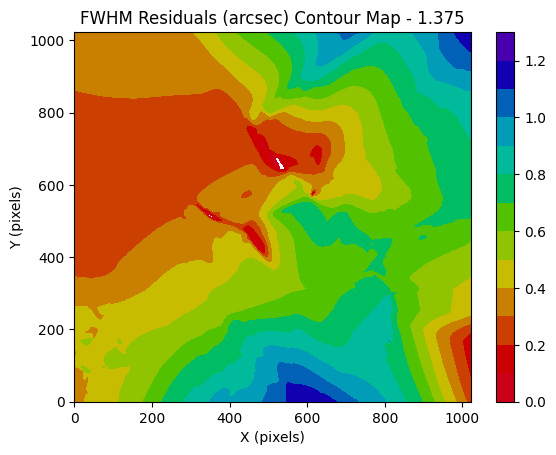

loess_2d beginning
loess_2d done


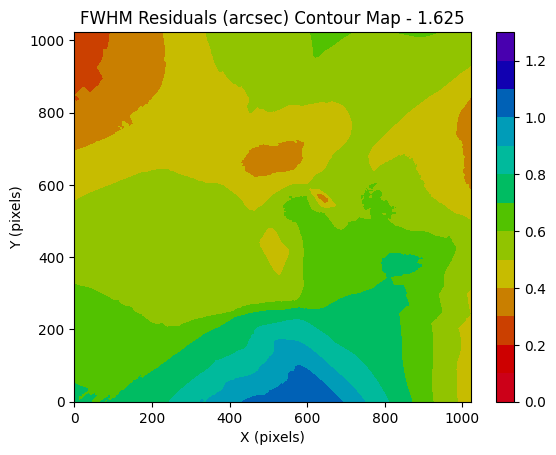

loess_2d beginning
loess_2d done


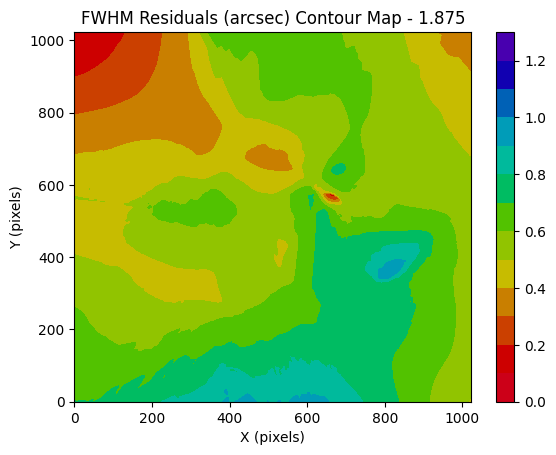

loess_2d beginning
loess_2d done


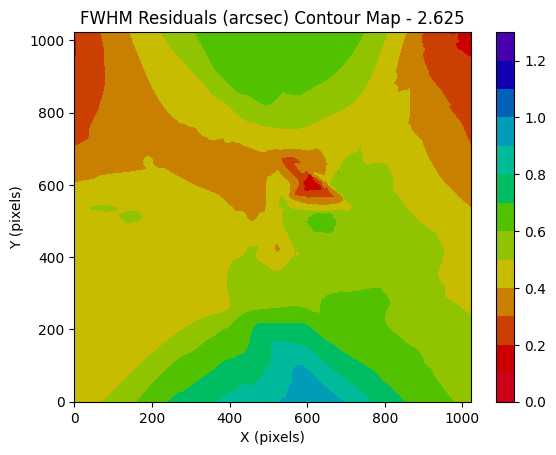

loess_2d beginning
loess_2d done


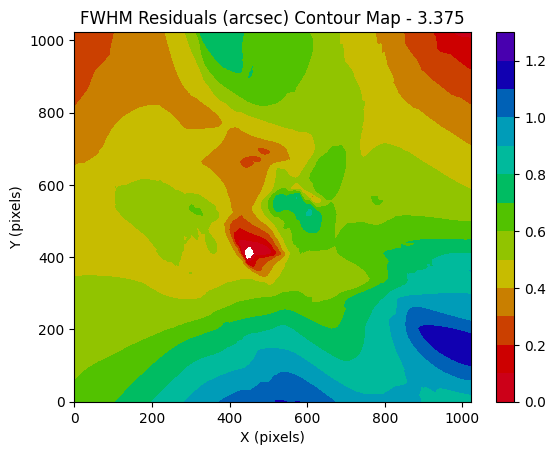

In [ ]:
reddir = Path(f'C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-06-26/raw-reduced/')
directories = [dir for dir in reddir.iterdir() if ('Focus' not in str(dir) and 
                                                   'NGC' not in str(dir))]
graph_topographic(directories, condition_tuples=conditions_06_26, 
                  frac=0.3, verbose=False)

USING frac=0.5

loess_2d beginning
loess_2d done


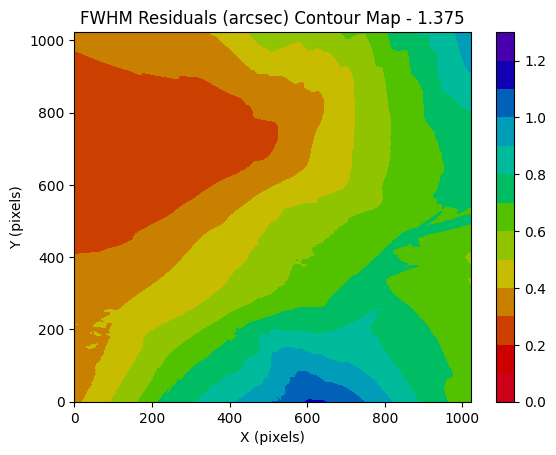

loess_2d beginning
loess_2d done


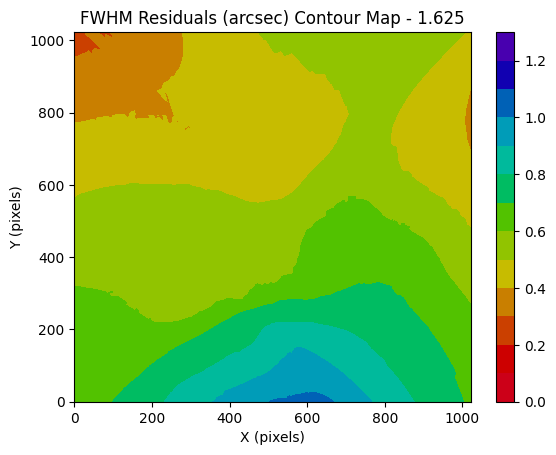

loess_2d beginning
loess_2d done


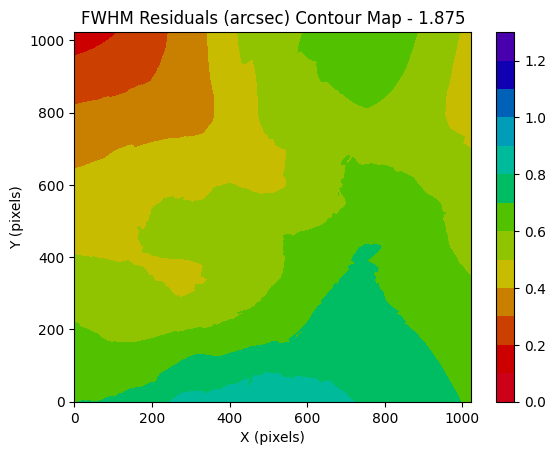

loess_2d beginning
loess_2d done


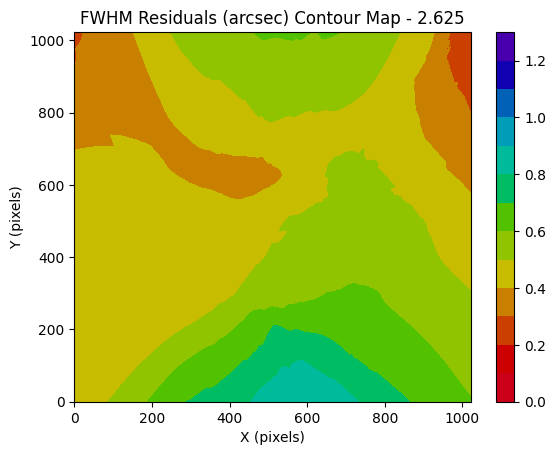

loess_2d beginning
loess_2d done


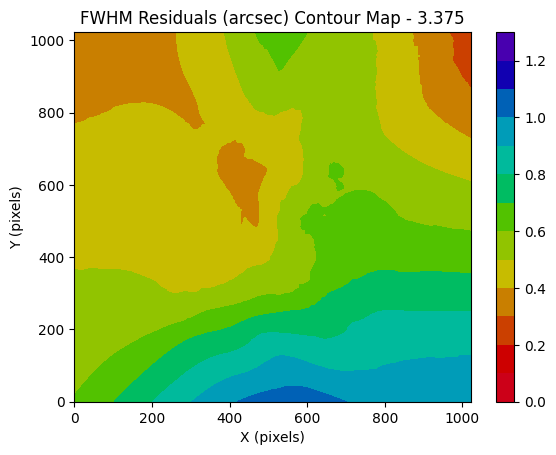

In [ ]:
reddir = Path(f'C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-06-26/raw-reduced/')
directories = [dir for dir in reddir.iterdir() if ('Focus' not in str(dir) and 
                                                   'NGC' not in str(dir))]
graph_topographic(directories, condition_tuples=conditions_06_26, 
                  frac=0.5, verbose=False)